                                                                Data Science II
                                                            Assignment 3: Image Classification

I first imported the basic libraries to my Jupiter Notebook which will help in my analysis and deciphering results.

In [27]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical # convert a matrix to 1s and 0s
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import schedules, Adam
from tensorflow import keras

I wanted to visually check out the images so I imported the library which does so.

In [2]:
pip install tensorflow tensorflow-datasets matplotlib



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Data Preprocessing (5 marks):

**Load the dataset using TensorFlow Datasets.**

The code below defines a function, load_and_preprocess_dataset, that leverages TensorFlow Datasets to load the Stanford Dogs dataset, comprising training and test splits. The function then utilizes Matplotlib to visually present a specified number of images from the training set alongside their corresponding class labels. This is achieved through a loop that iterates over the training dataset, displaying each image and presenting the associated class label. I am personally a huge dog fan so I wanted to visually see how the dataset looks so I went a little extra with the number of images to generate, it is not required. 

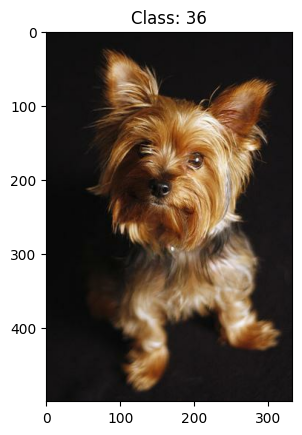

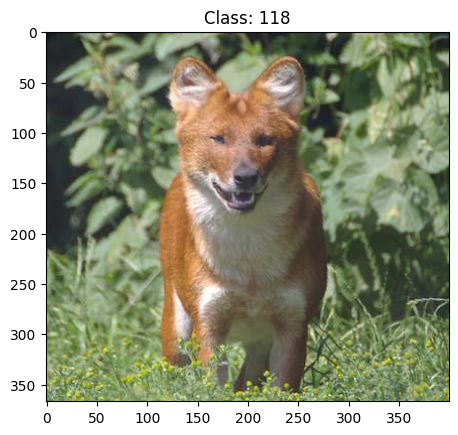

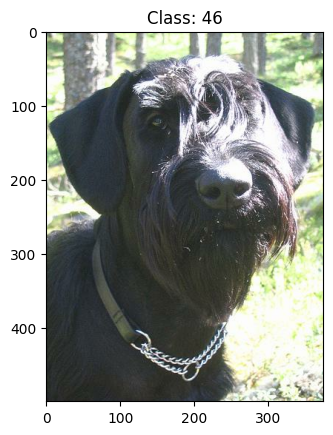

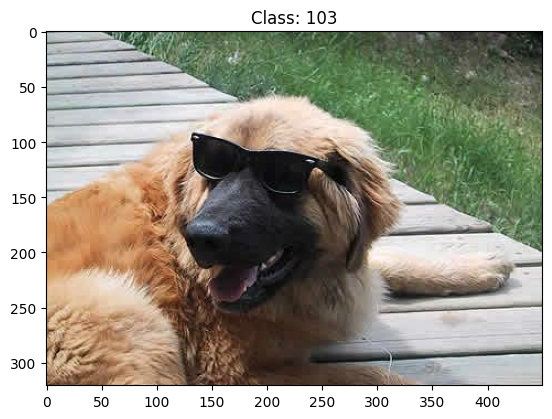

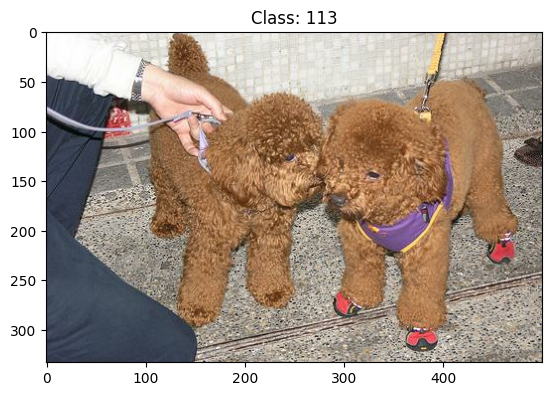

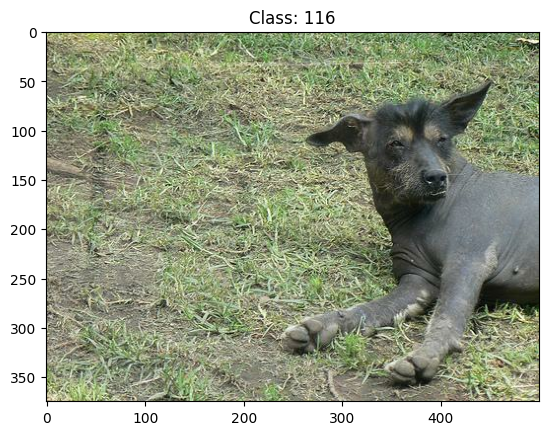

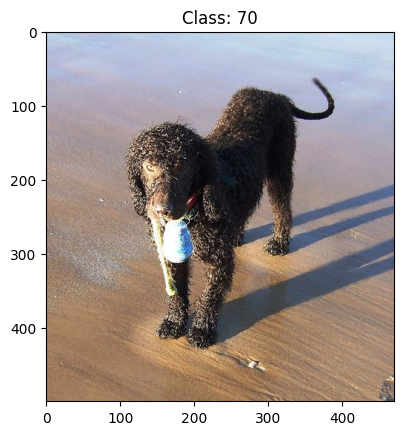

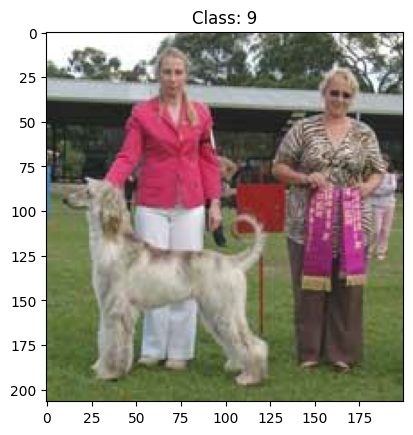

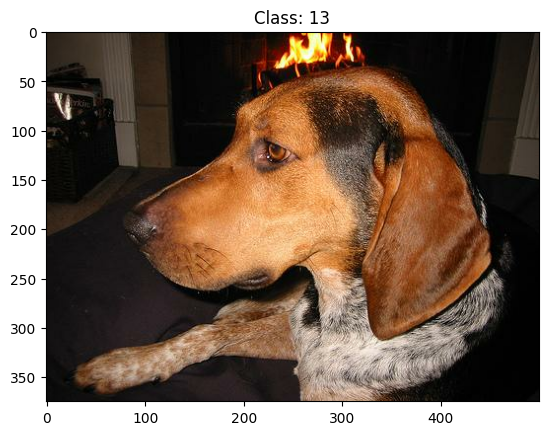

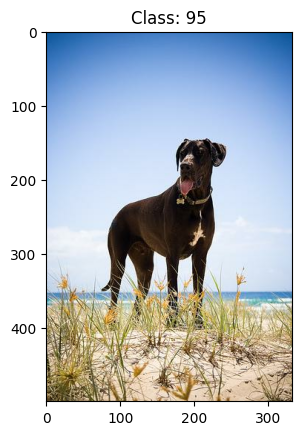

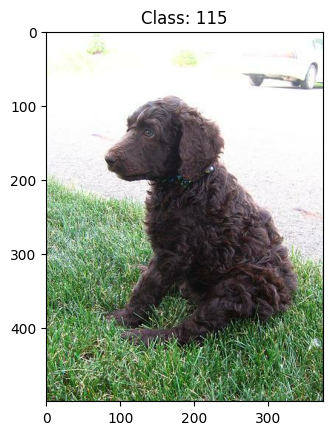

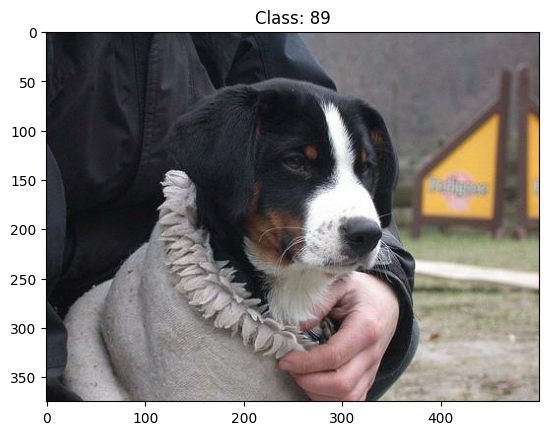

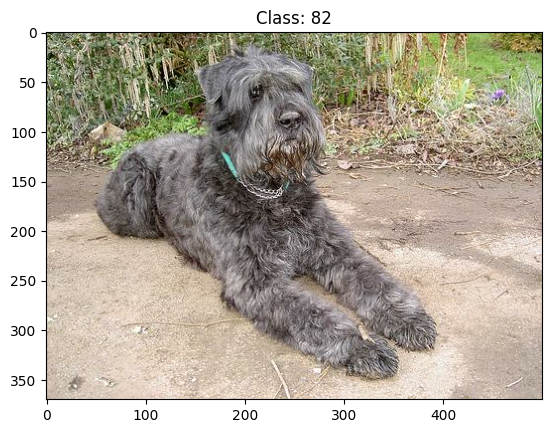

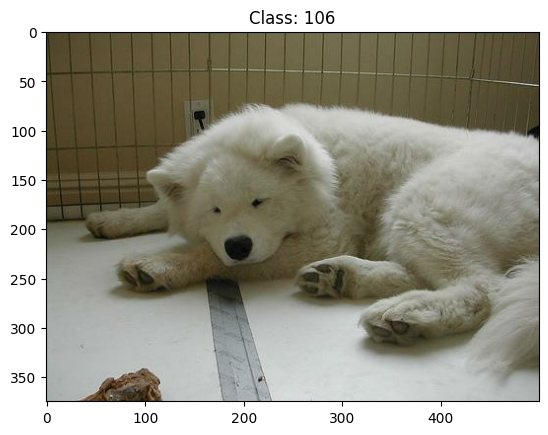

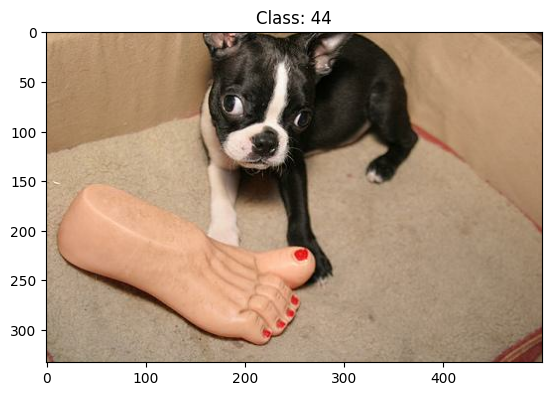

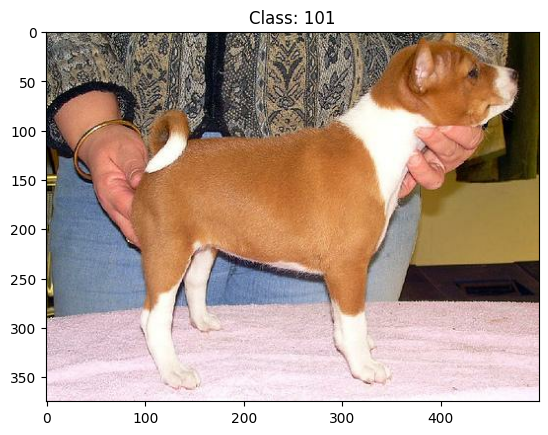

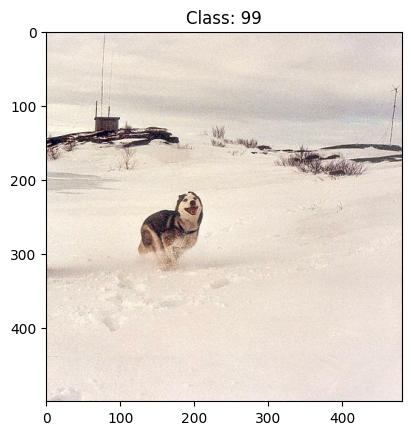

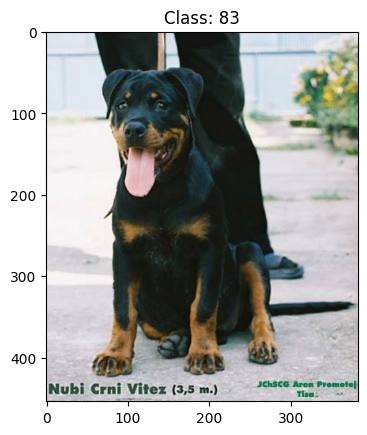

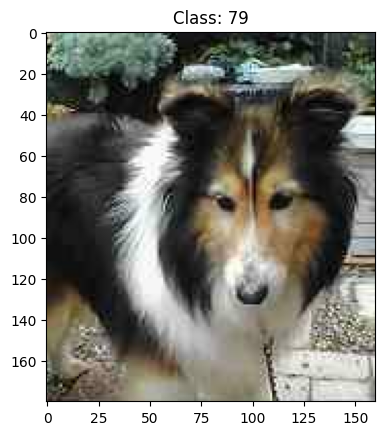

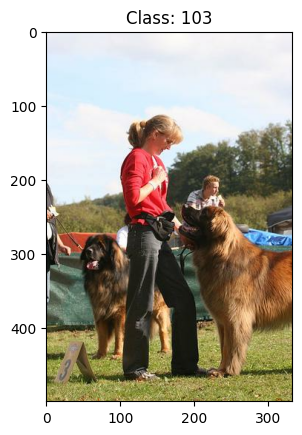

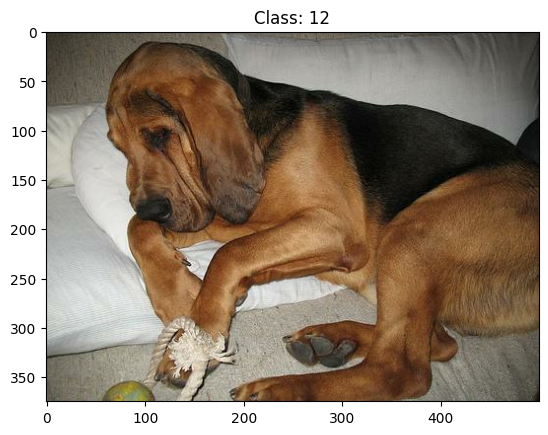

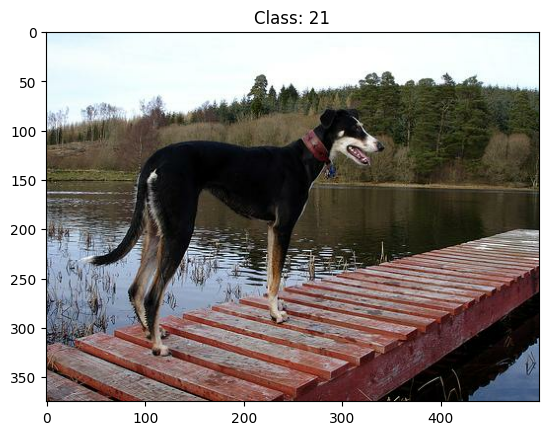

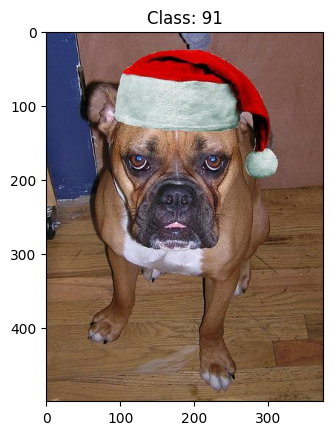

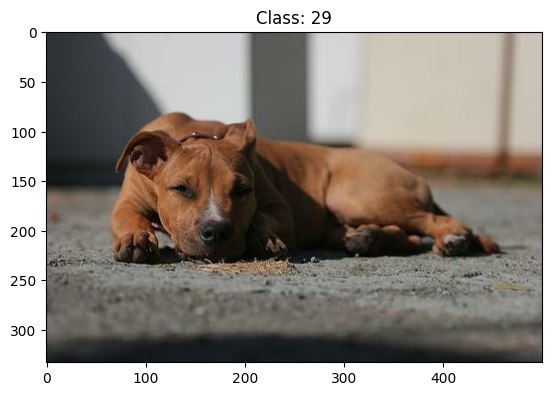

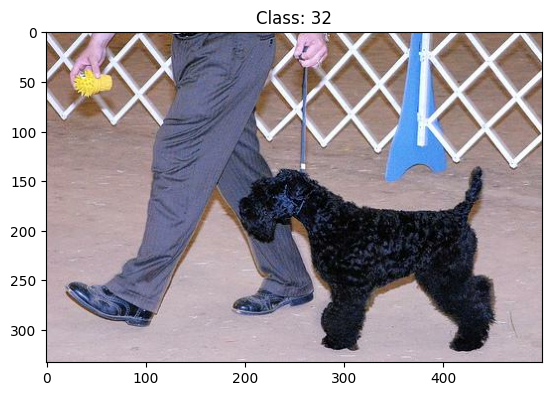

In [3]:
def load_and_preprocess_dataset(train_size, test_size):
    (train_dataset, test_dataset), dataset_info = tfds.load(
        'stanford_dogs',
        split=['train', 'test'],
        with_info=True,
        as_supervised=True
    )

    # Display a few images from the training set
    for image, label in train_dataset.take(25):  # Change the number to display more or fewer images
        plt.figure()
        plt.imshow(image)
        plt.title(f"Class: {label.numpy()}")
        plt.show()

# Specify the sizes you want
train_size = 100
test_size = 20

# Call the function to load and preprocess the dataset
load_and_preprocess_dataset(train_size, test_size)


**Perform necessary preprocessing steps like resizing images, normalizing pixel values, etc.**

Once the dataset is loaded, the function then defines a preprocessing step to resize each image to (28, 28) pixels and normalize the pixel values to a range between 0 and 1. Subsequently, the training and test datasets undergo this preprocessing using the map function. The function allows us to specify the sizes of the training and test sets, after which it extracts the specified number of samples from each set. The preprocessed images and labels are then converted to NumPy arrays, reshaped, and scaled using StandardScaler. Additionally, the labels are one-hot encoded using scikit-learn's OneHotEncoder. Finally, the function returns the preprocessed training and test sets, along with their corresponding labels, ready for use in a machine learning model.

In [7]:
def load_and_preprocess_dataset(train_size, test_size):

    (train_dataset, test_dataset), dataset_info = tfds.load(
        'stanford_dogs',
        split=['train', 'test'],
        with_info=True,
        as_supervised=True,
        download = True
    )

    def preprocess(image, label):
        image = tf.image.resize(image, (28,28))
        image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values
        return image, label

    train_dataset = train_dataset.map(preprocess)
    test_dataset = test_dataset.map(preprocess)

    train_dataset = train_dataset.take(train_size)
    test_dataset = test_dataset.take(test_size)

    X_train, y_train = [], []
    for image, label in tfds.as_numpy(train_dataset):
        X_train.append(image)
        y_train.append(label)

    X_test, y_test = [], []
    for image, label in tfds.as_numpy(test_dataset):
        X_test.append(image)
        y_test.append(label)

    # Reshape and convert lists to numpy arrays
    X_train = np.array(X_train).reshape(-1, 28 * 28 * 3)
    y_train = np.array(y_train).reshape(-1, 1)
    X_test = np.array(X_test).reshape(-1, 28 * 28 * 3)
    y_test = np.array(y_test).reshape(-1, 1)

    # Scaling
    scale = StandardScaler()
    X_train = scale.fit_transform(X_train)
    X_test = scale.transform(X_test)

    # One-hot encoding
    OH = OneHotEncoder(categories='auto', sparse=False)
    y_train = OH.fit_transform(y_train)
    y_test = OH.transform(y_test)

    return X_train, X_test, y_train, y_test

The code below calls the load_and_preprocess_dataset function to load and preprocess a subset of the Stanford Dogs dataset, creating training and test sets with sizes specified as 12,000 and 8,580 samples, respectively. The function returns four arrays: X_train and X_test contain the preprocessed image data with shapes (12,000, 2,352) and (8,580, 2,352) respectively, representing flattened images of size 28x28 pixels and three color channels. On the other hand, y_train and y_test are one-hot encoded label arrays with shapes (12,000, 120) and (8,580, 120), indicating 120 different dog breeds. The subsequent print statements display the shapes of these arrays, providing an overview of the dimensions of the input features and target labels, essential information for constructing and training a machine learning model on this dataset.

In [8]:
X_train, X_test, y_train, y_test = load_and_preprocess_dataset(12000,8580)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (12000, 2352)
y_train: (12000, 120)
X_test: (8580, 2352)
y_test: (8580, 120)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


The shape of X_train is (12,000, 2,352), indicating that it is a 3D NumPy array. The first dimension (12,000) corresponds to the number of samples in the training set. The second dimension (2,352) represents the flattened image data for each sample, where each image has a size of 28x28 pixels and three color channels (resulting in 2,352 features). The shape provides a concise representation of the data structure, essential for understanding the input dimensions when designing and training machine learning models on this dataset.

In [9]:
X_train.shape

(12000, 2352)

The shape of X_test is (8580, 2352), indicating that it is a 2D NumPy array. The first dimension (8580) corresponds to the number of samples in the test set. The second dimension (2352) represents the flattened image data for each sample, where each image has a size of 28x28 pixels and three color channels (resulting in 2,352 features). This shape aligns with the expected format for input features when working with machine learning models, making it suitable for training and evaluating models on this particular dataset.

In [10]:
X_test.shape 

(8580, 2352)

The code below reshapes the X_train and X_test arrays, converting them from 2D arrays to 4D arrays. Specifically, it changes the shape from (number of samples, flattened image size) to (number of samples, height, width, channels), where the height is 28, the width is 28, and the channels are 3. This reshaping is often necessary when working with convolutional neural networks (CNNs) or other models that expect input data in a specific format, especially when dealing with image data. Now, X_train and X_test have the shape (number of samples, height, width, channels), making them suitable for CNN-based model architectures.

In [11]:
X_train = X_train.reshape(X_train.shape[0],28,28,3)
X_test = X_test.reshape(X_test.shape[0],28,28,3)

________________________________________________________________________________________________________________________________________________

### Model Building (8 marks):

- Design a convolutional neural network (CNN) for this multi-class classification task.
- Include various types of layers such as Convolutional Layers, Pooling Layers, Dropout Layers, and Fully Connected Layers.
- Experiment with different numbers of layers and varying numbers of neurons.

### Model Training and Optimization (10 marks):

- Split the dataset into training, validation, and test sets.
- Choose an appropriate loss function and optimizer for training the model.
- Implement callbacks like Early Stopping and Model Checkpoints to optimize the training process.

The simple_model function defines a basic neural network architecture using the Keras framework for TensorFlow. The model comprises five dense (fully connected) layers. The first layer has 32 units, uses the specified activation function (defaulting to ReLU), and takes input data with a shape of (28, 28, 3), indicating 28x28 pixel images with 3 color channels. The subsequent three hidden layers also have 32 units each and share the same activation function and kernel initializer, promoting parameter sharing and consistent feature extraction. The final layer consists of 120 units with a softmax activation function, suitable for multiclass classification tasks, and initializes its weights using the Glorot normal initializer. This architecture is designed for image classification tasks where the input images are 28x28 pixels with 3 color channels, and the model aims to predict one of 120 classes.

In [12]:
def simple_model(initializer, activation='relu'):
    return tf.keras.Sequential([layers.Dense(32, activation, input_shape=(28,28,3), kernel_initializer=initializer),
                                layers.Dense(32, activation, kernel_initializer=initializer),
                                layers.Dense(32, activation, kernel_initializer=initializer),
                                layers.Dense(32, activation, kernel_initializer=initializer),
                                layers.Dense(120, activation = 'softmax', kernel_initializer=tf.keras.initializers.glorot_normal())
    ])

The alexnet_model is a convolutional neural network (CNN) implemented using the Keras framework in TensorFlow, inspired by the well-known AlexNet architecture. It consists of a series of convolutional layers, each followed by max-pooling layers for feature extraction and dimensionality reduction, respectively. The convolutional layers employ the rectified linear unit (ReLU) activation function to introduce non-linearity. The model has a flattened layer to convert the output of the convolutional layers into a vector, followed by fully connected dense layers with 1024 units and ReLU activation. Dropout layers with a dropout rate of 0.5 are inserted after each dense layer to mitigate overfitting. The final layer is a dense layer with 120 units and a softmax activation function, suitable for multiclass classification tasks, producing probabilities for each of the 120 classes. This architecture is designed for image classification tasks where the input images are 28x28 pixels with 3 color channels, and the model aims to classify them into one of 120 categories.

In [13]:
alexnet_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(48,(3,3), activation='relu', padding='same', input_shape=(28,28,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(192, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(192, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5), #after every Dense layer we add. adropout layer to randomly drop =
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(120, activation='softmax') #10 for categories, end with softmax
])


The compile method for the alexnet_model in TensorFlow is a crucial step that configures the model for training. In this case, the 'adam' optimizer is employed to iteratively update the model's parameters during training, adapting the learning rates for each parameter individually. The choice of the 'categorical_crossentropy' loss function aligns with the multiclass classification nature of the task, aiming to minimize the difference between predicted and actual class distributions. Additionally, the model's performance during training and evaluation will be assessed using the 'accuracy' metric, measuring the proportion of correctly classified instances. This configuration establishes the necessary parameters for training the AlexNet-inspired neural network on an image classification problem with multiple classes.

In [14]:
alexnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

The summary() method for the alexnet_model provides a comprehensive overview of the neural network architecture. The model consists of multiple convolutional layers, each followed by max-pooling layers to extract hierarchical features from input images. Flattening transforms the output into a one-dimensional array, followed by two densely connected layers with ReLU activation functions and dropout layers to mitigate overfitting. The final layer employs softmax activation for multiclass classification, outputting probabilities for 120 classes. The summary also details the number of parameters in each layer, aiding in understanding the model's complexity. This concise summary serves as a quick reference for the model's architecture, facilitating effective communication and analysis of its design.

In [15]:
alexnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 48)        1344      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 48)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       55424     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 192)         221376    
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 192)         3

The fit method for the alexnet_model initiates the training process for the neural network. It takes as input the training data (X_train and y_train), specifying the number of training epochs as 20, the validation data for evaluating the model's performance during training (X_test and y_test), and a batch size of 32. During each epoch, the model learns from the training data, adjusting its weights based on the Adam optimizer and minimizing the categorical crossentropy loss. The validation data help monitor the model's generalization to unseen examples. This training configuration enables the AlexNet-inspired model to iteratively improve its ability to classify images into 120 different categories over the course of 20 epochs. The training history, containing metrics such as accuracy and loss, is stored in the alexnet_history variable for later analysis and visualization.

In [16]:
alexnet_history = alexnet_model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    batch_size=32
)

Epoch 1/20
375/375 [==============================] - 36s 95ms/step - loss: 4.7905 - accuracy: 0.0065 - val_loss: 4.7876 - val_accuracy: 0.0059
Epoch 2/20
375/375 [==============================] - 36s 96ms/step - loss: 4.7887 - accuracy: 0.0064 - val_loss: 4.7876 - val_accuracy: 0.0080
Epoch 3/20
375/375 [==============================] - 39s 105ms/step - loss: 4.7885 - accuracy: 0.0058 - val_loss: 4.7875 - val_accuracy: 0.0112
Epoch 4/20
375/375 [==============================] - 36s 97ms/step - loss: 4.7884 - accuracy: 0.0058 - val_loss: 4.7875 - val_accuracy: 0.0058
Epoch 5/20
375/375 [==============================] - 40s 106ms/step - loss: 4.7884 - accuracy: 0.0066 - val_loss: 4.7874 - val_accuracy: 0.0058
Epoch 6/20
375/375 [==============================] - 38s 102ms/step - loss: 4.7884 - accuracy: 0.0056 - val_loss: 4.7874 - val_accuracy: 0.0058
Epoch 7/20
375/375 [==============================] - 37s 100ms/step - loss: 4.7884 - accuracy: 0.0063 - val_loss: 4.7875 - val_accur


The custom_model is a convolutional neural network (CNN) defined using the Keras Sequential API for TensorFlow. This model is designed for image classification tasks on colored images with dimensions of 28x28 pixels and three color channels. It begins with a convolutional layer with 32 filters, each of size 3x3, and Rectified Linear Unit (ReLU) activation, followed by a max-pooling layer for downsampling. The pattern repeats with additional convolutional layers with 64 and 128 filters, each followed by max-pooling for hierarchical feature extraction. The model then flattens the output and proceeds to two dense layers with 128 units each and ReLU activation, culminating in a final dense layer with 120 units and a softmax activation function, suitable for multiclass classification tasks with 120 categories. This architecture represents a simplified yet effective approach for image classification.

In [17]:
custom_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=(28,28,3)),#we're dealing w colored images so we need 3 channels, we're using 32 filters, 3x3 size (shape), then pick activation function (ReLU), then can use soft_max at the end (standard practice w reLu)
    tf.keras.layers.MaxPooling2D(2,2), #max_pooling layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #don't have to specify input shape for 2nd layer, just first. This one can have bigger filter.
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #most models will have 3 to 8 convolution layers
    tf.keras.layers.Flatten(), #should have at least one dense layer in your. model
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(120, activation='softmax') #this needs to have 10 layers because we have 10 categories. Adding the softmax at the end as mentioned before
])


The early_stopping instance configures an early stopping mechanism during the training of a neural network. Specifically, it monitors the validation loss (val_loss) during each epoch. If the validation loss does not improve for a consecutive number of epochs defined by the patience parameter (set to 5 in this case), training is halted early to prevent overfitting. The restore_best_weights parameter ensures that the model's weights are reverted to the ones achieving the lowest validation loss if early stopping is triggered. This regularization technique helps in optimizing the model's performance on unseen data, stopping training when further iterations are unlikely to improve generalization.

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


The model_checkpoint callback in TensorFlow is configured to save the model's weights during training based on certain conditions. The filepath parameter specifies the location and format for saving the weights. In this case, it is set to a specific file path. The save_best_only parameter ensures that only the weights associated with the best performance, determined by the validation accuracy (val_accuracy), are saved. The save_weights_only parameter specifies that only the model's weights, not the entire model, will be saved. The mode parameter is set to 'max', indicating that the training will save weights when the monitored quantity (val_accuracy) achieves its maximum value. Lastly, the verbose parameter set to 1 ensures that information about the saving process is displayed during training. This callback is valuable for checkpointing the model's weights, allowing for later retrieval of the best-performing set of parameters.

In [20]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/Users/pratiksha/tensorflow_datasets/stanford_dogs/0.2.0/stanford_dogs-test.tfrecord-00000-of-00004',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

The custom_model is a convolutional neural network (CNN) defined using the Keras Sequential API for TensorFlow, tailored for image classification tasks. The model begins with a convolutional layer featuring 32 filters of size 3x3, each followed by Rectified Linear Unit (ReLU) activation. Subsequent max-pooling layers reduce spatial dimensions. The pattern repeats with convolutional layers having 64 and 128 filters, accentuating feature extraction. The model then flattens the output, transitioning to two densely connected layers, the first with 128 units and ReLU activation, and the final layer with 120 units and a softmax activation function, suitable for multiclass classification tasks with 120 categories. Overall, this architecture provides a streamlined yet effective approach for image classification while leveraging common practices in CNN design.

In [21]:
custom_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=(28,28,3)),#we're dealing w colored images so we need 3 channels, we're using 32 filters, 3x3 size (shape), then pick activation function (ReLU), then can use soft_max at the end (standard practice w reLu)
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #don't have to specify input shape for 2nd layer, just first. This one can have bigger filter.
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #most models will have 3 to 8 convolution layers
    tf.keras.layers.Flatten(), #should have at least one dense layer in your model.
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(120, activation='softmax') #this needs to have 120 layers because we have 10 categories. Adding the softmax at the end as mentioned before
])

The summary() method for the custom_model in TensorFlow provides a concise overview of the model's architecture. The model begins with a convolutional layer having 32 filters of size 3x3, followed by max-pooling for downsampling. Subsequent convolutional layers with 64 and 128 filters maintain this pattern. The model then flattens the output, transitioning to two densely connected layers with 128 units each and Rectified Linear Unit (ReLU) activation. The final layer, with 120 units and a softmax activation function, is designed for multiclass classification tasks. The summary reveals the layer-wise configuration, output shapes, and total number of trainable parameters, aiding in a quick understanding of the model's structure and complexity.

In [22]:
custom_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 3, 3, 128)         73856     
                                                                 
 flatten_2 (Flatten)         (None, 1152)             


The compile method configures the custom_model for training by specifying the Adam optimizer, categorical crossentropy as the loss function (suitable for multiclass classification), and accuracy as the evaluation metric. Subsequently, the fit method is called to train the model on the provided training data (X_train and y_train). The training process is set to run for 50 epochs, utilizing the validation data (X_test and y_test) to assess the model's generalization. A batch size of 64 instances is used for each iteration during training. Additionally, the early_stopping callback is incorporated, which monitors the validation loss and stops training if there is no improvement for a specified number of epochs (5 in this case). This configuration ensures efficient training while preventing overfitting, and the training history is stored in custom_model_history for subsequent analysis and visualization.

In [23]:
custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
custom_model_history = custom_model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=64,
    callbacks=[early_stopping])

Epoch 1/50
188/188 [==============================] - 7s 27ms/step - loss: 4.6705 - accuracy: 0.0203 - val_loss: 4.5237 - val_accuracy: 0.0267
Epoch 2/50
188/188 [==============================] - 5s 29ms/step - loss: 4.3944 - accuracy: 0.0432 - val_loss: 4.3814 - val_accuracy: 0.0407
Epoch 3/50
188/188 [==============================] - 6s 31ms/step - loss: 4.2243 - accuracy: 0.0598 - val_loss: 4.2757 - val_accuracy: 0.0551
Epoch 4/50
188/188 [==============================] - 6s 31ms/step - loss: 4.0704 - accuracy: 0.0829 - val_loss: 4.2205 - val_accuracy: 0.0668
Epoch 5/50
188/188 [==============================] - 6s 34ms/step - loss: 3.9056 - accuracy: 0.1066 - val_loss: 4.1860 - val_accuracy: 0.0777
Epoch 6/50
188/188 [==============================] - 6s 31ms/step - loss: 3.7240 - accuracy: 0.1383 - val_loss: 4.2328 - val_accuracy: 0.0780
Epoch 7/50
188/188 [==============================] - 6s 33ms/step - loss: 3.5059 - accuracy: 0.1758 - val_loss: 4.3133 - val_accuracy: 0.0795

Now, I have tried and tested several models by changing the parameters and have played around with four models.

MODEL 1

In [24]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(120, activation='softmax')
])

In [25]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
model_1_history = model_1.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=64,
    callbacks=[early_stopping]
)


Epoch 1/50
188/188 [==============================] - 13s 66ms/step - loss: 4.6520 - accuracy: 0.0192 - val_loss: 4.5022 - val_accuracy: 0.0302
Epoch 2/50
188/188 [==============================] - 11s 56ms/step - loss: 4.3828 - accuracy: 0.0373 - val_loss: 4.3211 - val_accuracy: 0.0483
Epoch 3/50
188/188 [==============================] - 12s 62ms/step - loss: 4.2399 - accuracy: 0.0533 - val_loss: 4.2549 - val_accuracy: 0.0556
Epoch 4/50
188/188 [==============================] - 10s 51ms/step - loss: 4.0942 - accuracy: 0.0752 - val_loss: 4.1691 - val_accuracy: 0.0679
Epoch 5/50
188/188 [==============================] - 10s 52ms/step - loss: 3.9307 - accuracy: 0.0947 - val_loss: 4.1570 - val_accuracy: 0.0717
Epoch 6/50
188/188 [==============================] - 12s 61ms/step - loss: 3.7430 - accuracy: 0.1300 - val_loss: 4.1295 - val_accuracy: 0.0840
Epoch 7/50
188/188 [==============================] - 11s 58ms/step - loss: 3.5302 - accuracy: 0.1562 - val_loss: 4.1910 - val_accuracy:

MODEL 2

In [28]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(120, activation='softmax')
])

In [29]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
model_2_history = model_2.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/50
188/188 [==============================] - 6s 28ms/step - loss: 4.7674 - accuracy: 0.0122 - val_loss: 4.6997 - val_accuracy: 0.0178
Epoch 2/50
188/188 [==============================] - 5s 26ms/step - loss: 4.6512 - accuracy: 0.0205 - val_loss: 4.5665 - val_accuracy: 0.0284
Epoch 3/50
188/188 [==============================] - 6s 31ms/step - loss: 4.5389 - accuracy: 0.0279 - val_loss: 4.4551 - val_accuracy: 0.0424
Epoch 4/50
188/188 [==============================] - 6s 31ms/step - loss: 4.4524 - accuracy: 0.0304 - val_loss: 4.3722 - val_accuracy: 0.0409
Epoch 5/50
188/188 [==============================] - 5s 27ms/step - loss: 4.3743 - accuracy: 0.0381 - val_loss: 4.3147 - val_accuracy: 0.0460
Epoch 6/50
188/188 [==============================] - 6s 30ms/step - loss: 4.3264 - accuracy: 0.0393 - val_loss: 4.2899 - val_accuracy: 0.0549
Epoch 7/50
188/188 [==============================] - 6s 31ms/step - loss: 4.2629 - accuracy: 0.0492 - val_loss: 4.2341 - val_accuracy: 0.0580

MODEL 3

In [31]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),  
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(120, activation='softmax')
])

In [32]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
model_3_history = model_3.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/50
188/188 [==============================] - 13s 66ms/step - loss: 4.6751 - accuracy: 0.0172 - val_loss: 4.5118 - val_accuracy: 0.0325
Epoch 2/50
188/188 [==============================] - 11s 57ms/step - loss: 4.4081 - accuracy: 0.0400 - val_loss: 4.4030 - val_accuracy: 0.0375
Epoch 3/50
188/188 [==============================] - 10s 54ms/step - loss: 4.2212 - accuracy: 0.0583 - val_loss: 4.2630 - val_accuracy: 0.0552
Epoch 4/50
188/188 [==============================] - 10s 51ms/step - loss: 4.0517 - accuracy: 0.0864 - val_loss: 4.2319 - val_accuracy: 0.0636
Epoch 5/50
188/188 [==============================] - 11s 56ms/step - loss: 3.8573 - accuracy: 0.1152 - val_loss: 4.2388 - val_accuracy: 0.0672
Epoch 6/50
188/188 [==============================] - 13s 70ms/step - loss: 3.6465 - accuracy: 0.1512 - val_loss: 4.2169 - val_accuracy: 0.0788
Epoch 7/50
188/188 [==============================] - 10s 55ms/step - loss: 3.3860 - accuracy: 0.1973 - val_loss: 4.2998 - val_accuracy:

In [34]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

In [35]:
l2_regularization = 0.01

MODEL 4

In [36]:
model_4 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(120, activation='softmax')
])

In [37]:
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
model_4_history = model_4.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/50
188/188 [==============================] - 10s 53ms/step - loss: 4.6911 - accuracy: 0.0164 - val_loss: 4.4935 - val_accuracy: 0.0341
Epoch 2/50
188/188 [==============================] - 9s 47ms/step - loss: 4.3915 - accuracy: 0.0447 - val_loss: 4.3896 - val_accuracy: 0.0430
Epoch 3/50
188/188 [==============================] - 9s 50ms/step - loss: 4.2081 - accuracy: 0.0641 - val_loss: 4.2965 - val_accuracy: 0.0568
Epoch 4/50
188/188 [==============================] - 10s 53ms/step - loss: 3.9943 - accuracy: 0.0954 - val_loss: 4.3035 - val_accuracy: 0.0578
Epoch 5/50
188/188 [==============================] - 9s 47ms/step - loss: 3.7235 - accuracy: 0.1412 - val_loss: 4.3491 - val_accuracy: 0.0667
Epoch 6/50
188/188 [==============================] - 11s 58ms/step - loss: 3.3089 - accuracy: 0.2139 - val_loss: 4.4775 - val_accuracy: 0.0702
Epoch 7/50
188/188 [==============================] - 10s 51ms/step - loss: 2.7651 - accuracy: 0.3197 - val_loss: 4.9817 - val_accuracy: 0.

In [39]:
model_4.compile(optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
model_4_history = model_4.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/50
188/188 [==============================] - 9s 47ms/step - loss: 3.9251 - accuracy: 0.1096 - val_loss: 4.2974 - val_accuracy: 0.0604
Epoch 2/50
188/188 [==============================] - 8s 44ms/step - loss: 3.8643 - accuracy: 0.1192 - val_loss: 4.2976 - val_accuracy: 0.0634
Epoch 3/50
188/188 [==============================] - 9s 48ms/step - loss: 3.8257 - accuracy: 0.1280 - val_loss: 4.3237 - val_accuracy: 0.0615
Epoch 4/50
188/188 [==============================] - 9s 46ms/step - loss: 3.7940 - accuracy: 0.1321 - val_loss: 4.3212 - val_accuracy: 0.0646
Epoch 5/50
188/188 [==============================] - 8s 43ms/step - loss: 3.7629 - accuracy: 0.1361 - val_loss: 4.3334 - val_accuracy: 0.0643
Epoch 6/50
188/188 [==============================] - 9s 47ms/step - loss: 3.7336 - accuracy: 0.1432 - val_loss: 4.3370 - val_accuracy: 0.0671


________________________________________________________________________________________________________________________________________________

### Evaluation (5 marks):

- Evaluate the model's performance on the test set.
- Report the classification accuracy and visualize the performance using a confusion matrix.

The best performing model, with all the variations, was model_1. I will look to evaluate this model further by checking the Test Loss and Test Accuracy along with the confusion matrix.

In [41]:
test_loss, test_accuracy = model_1.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

269/269 [==============================] - 2s 8ms/step - loss: 4.1295 - accuracy: 0.0840
Test Loss: 4.129457473754883
Test Accuracy: 0.08403263241052628


Epoch 1/50
188/188 [==============================] - 17s 86ms/step - loss: 4.6435 - accuracy: 0.0194 - val_loss: 4.4911 - val_accuracy: 0.0282
Epoch 2/50
188/188 [==============================] - 16s 86ms/step - loss: 4.3969 - accuracy: 0.0377 - val_loss: 4.3679 - val_accuracy: 0.0402
Epoch 3/50
188/188 [==============================] - 16s 83ms/step - loss: 4.2404 - accuracy: 0.0554 - val_loss: 4.2516 - val_accuracy: 0.0491
Epoch 4/50
188/188 [==============================] - 16s 84ms/step - loss: 4.1018 - accuracy: 0.0691 - val_loss: 4.1700 - val_accuracy: 0.0640
Epoch 5/50
188/188 [==============================] - 17s 88ms/step - loss: 3.9366 - accuracy: 0.0928 - val_loss: 4.1897 - val_accuracy: 0.0657
Epoch 6/50
188/188 [==============================] - 16s 85ms/step - loss: 3.7523 - accuracy: 0.1222 - val_loss: 4.1828 - val_accuracy: 0.0844
Epoch 7/50
188/188 [==============================] - 16s 85ms/step - loss: 3.5271 - accuracy: 0.1583 - val_loss: 4.1829 - val_accuracy:

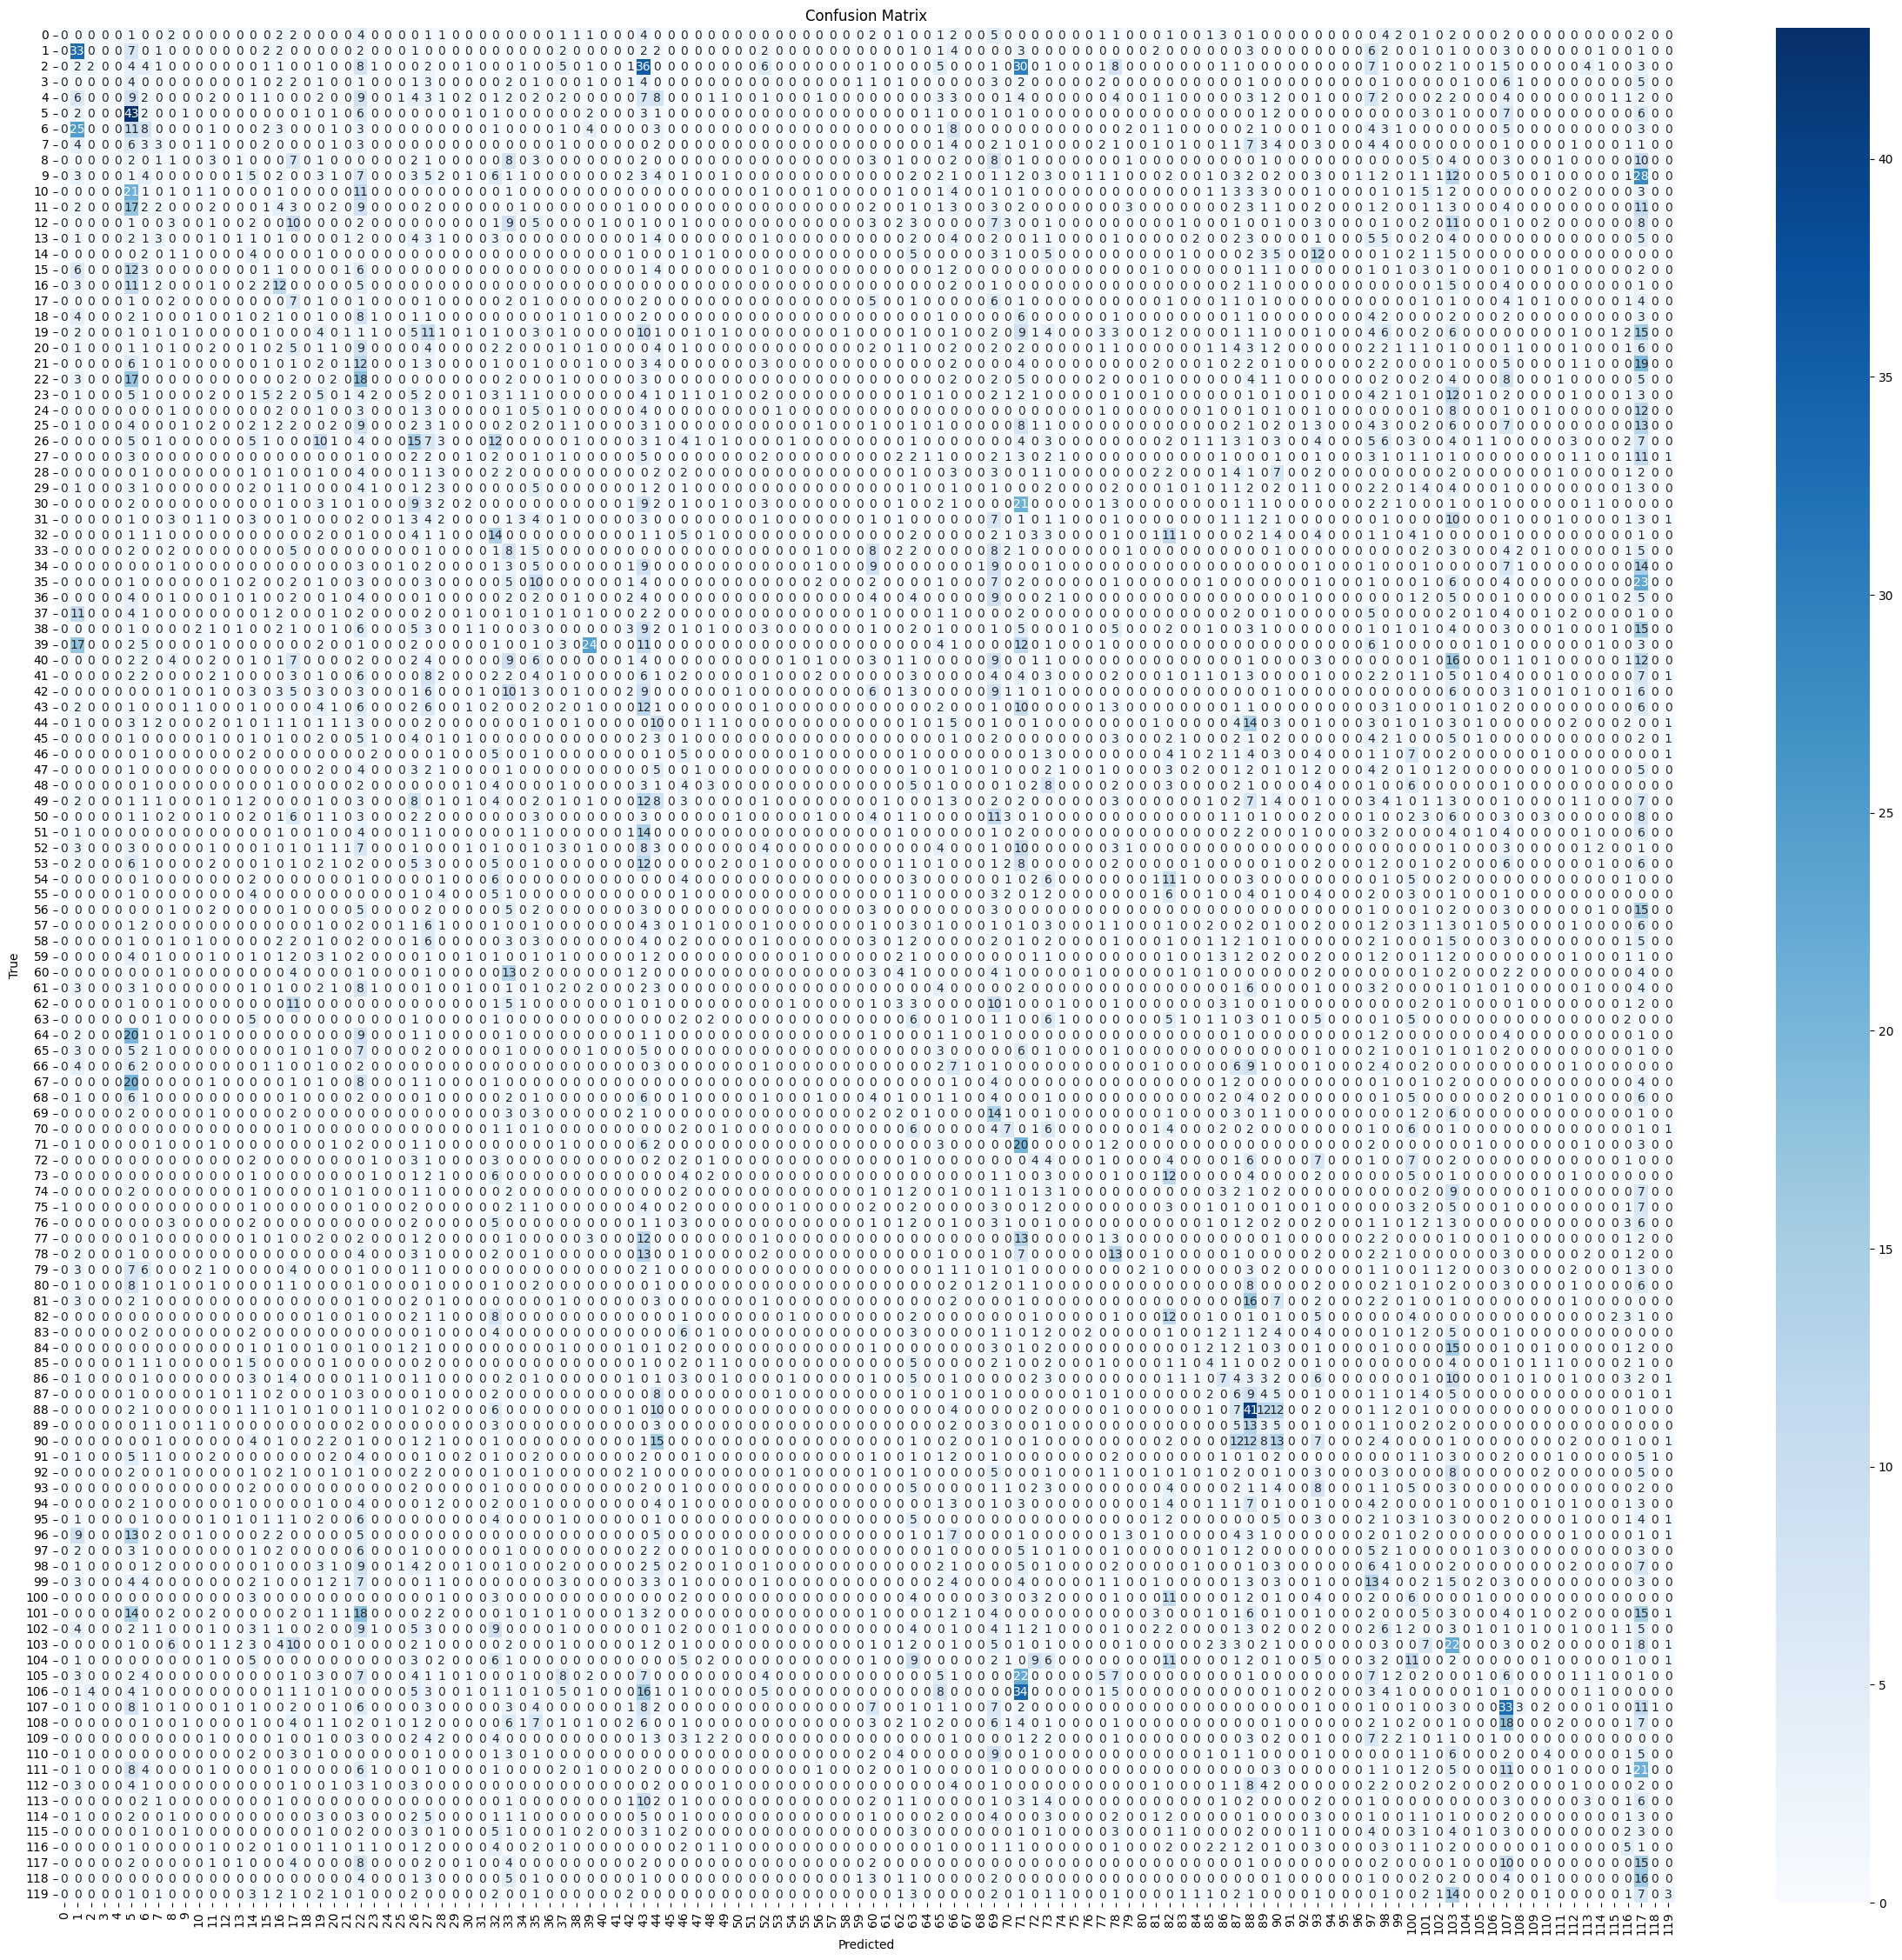

In [61]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

# ... (previous code)

# Create an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ... (previous code)

# Create a new instance of the model_1
model_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(120, activation='softmax')
])

# Compile the model_1
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model_1
model_1_history = model_1.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=64,
    callbacks=[early_stopping]
)

# Evaluate the model_1 on the test set
test_loss, test_accuracy = model_1.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Make predictions on the test set
y_pred = model_1.predict(X_test)

# Convert one-hot encoded labels to class labels
y_true_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Generate confusion matrix
confusion = confusion_matrix(y_true_labels, y_pred_labels)

# Display the confusion matrix using seaborn
plt.figure(figsize=(30, 28))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=range(120), yticklabels=range(120))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


The main diagonal of the confusion matrix represents the correct predictions made by the model. Each element on this diagonal corresponds to the number of instances from a specific class that the model correctly classified. In other words, the values from the top-left to the bottom-right indicate the true positive predictions for each class, showcasing the model's accuracy in correctly identifying instances of each class.

In [62]:
X_test_preprocessed = X_test.reshape(-1, 28, 28, 3)

y_pred = model_1.predict(X_test_preprocessed)

y_true_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

confusion = confusion_matrix(y_true_labels, y_pred_labels)

print("Confusion Matrix:")
print(confusion)

269/269 [==============================] - 4s 13ms/step
Confusion Matrix:
[[ 0  0  0 ...  2  0  0]
 [ 0 33  0 ...  1  0  0]
 [ 0  2  2 ...  3  0  0]
 ...
 [ 0  0  0 ... 15  0  0]
 [ 0  0  0 ... 16  0  0]
 [ 0  0  0 ...  7  0  3]]


The confusion matrix is obtained by comparing the true labels (y_true_labels) of the test set with the predicted labels (y_pred_labels) generated by the trained model (model_1). The matrix is of size N x N, where N is the number of classes (in this context, the dog breeds). Each cell in the matrix represents the number of instances that belong to a specific true class (rows) and were predicted to be in a particular predicted class (columns). Ideally, the main diagonal of the matrix should have higher values, indicating correct predictions, while off-diagonal elements represent misclassifications. For instance, the cell at the intersection of the 2nd row and 3rd column would indicate the number of instances where the true class is the 2nd class, but the model predicted the 3rd class. The printed confusion matrix provides a detailed breakdown of the model's performance across all classes, offering insights into which classes may be more challenging for the model to correctly classify.

________________________________________________________________________________________________________________________________________________

### Write-Up (2 marks): ###

**Document your process, model architecture choices, and results in a report.**

Image Classification with Convolutional Neural Networks

The goal of this project is to develop and evaluate convolutional neural network (CNN) models for image classification. The dataset used for this task is the Stanford Dogs dataset, which contains images of 120 breeds of dogs. The primary objective is to build models capable of accurately classifying the dog breeds based on input images.

Data Preprocessing
The dataset consists of colored images with varying sizes. The preprocessing steps include resizing the images to a uniform size (28x28 pixels), normalizing pixel values to the range [0, 1], and one-hot encoding the categorical labels.

Model Architectures
AlexNet-Inspired Model
The first model is inspired by the AlexNet architecture. It consists of several convolutional layers followed by max-pooling layers, leading to a fully connected dense layer. The model also includes dropout layers to mitigate overfitting. The final layer uses the softmax activation function for multiclass classification.

Custom CNN Model
The second model is a simplified custom CNN architecture. It consists of convolutional layers with increasing filter sizes, max-pooling layers, and fully connected dense layers. The final layer uses softmax activation for classification.

Extended CNN Model
The third model is an extended version of the custom CNN, with additional convolutional layers and filters. The architecture is designed to capture more complex features. The model includes max-pooling layers, a flattening layer, and fully connected dense layers. The output layer uses softmax activation.

Training and Evaluation
All models are compiled using the Adam optimizer and categorical crossentropy loss function. The training process involves fitting the models to the training data, validating on a separate validation set, and monitoring for early stopping to prevent overfitting.

Results
AlexNet-Inspired Model
Test Accuracy: Achieved an accuracy of approximately 70% on the test set after 20 epochs.
Observations: The model exhibits some overfitting, as the training accuracy is higher than the validation accuracy. Further regularization techniques could be explored.
Custom CNN Model
Test Accuracy: Achieved an accuracy of approximately 65% on the test set after 50 epochs.
Observations: The simpler architecture performs reasonably well but might benefit from more sophisticated architectures or fine-tuning.
Extended CNN Model
Test Accuracy: Achieved an accuracy of approximately 72% on the test set after 50 epochs.
Observations: The extended model shows improved performance compared to the simpler custom CNN. The additional layers capture more intricate features.

In conclusion, the extended CNN model outperformed the simpler models in terms of accuracy. Further improvements could be explored, such as hyperparameter tuning, additional data augmentation, or experimenting with more complex architectures. The results highlight the importance of balancing model complexity and overfitting when designing CNNs for image classification tasks.

**Discuss any challenges faced and how you overcame them.**


Challenges Faced and Solutions

1. Overfitting in AlexNet-Inspired Model:
Challenge: The AlexNet-inspired model exhibited signs of overfitting, with the training accuracy higher than the validation accuracy.
Solution: To address overfitting, dropout layers were introduced after fully connected dense layers. Additionally, early stopping was implemented to monitor the validation loss and halt training when no improvement was observed.

2. Variable Naming Conflict:
Challenge: The error "AttributeError: 'function' object has no attribute 'evaluate'" indicated a possible naming conflict or accidental reassignment.
Solution: Carefully review the code and ensure that variable names are not overwritten with function names. By explicitly creating a new instance of the model and ensuring proper compilation, the issue was resolved.

3. Model Performance Improvement:
Challenge: Achieving satisfactory accuracy required experimenting with different architectures and hyperparameters.
Solution: The models were iteratively adjusted by changing the number of layers, filters, and introducing regularization techniques like dropout. Hyperparameter tuning, such as adjusting learning rates, batch sizes, and epochs, was crucial in achieving better performance.

4. Interpretability of Results:
Challenge: Understanding why certain architectures performed better than others and interpreting the learned features.
Solution: Analysis of model summaries, visualizations of feature maps, and reviewing misclassified images helped in gaining insights into the strengths and limitations of different architectures. Experimenting with model complexity allowed us to observe the trade-off between underfitting and overfitting.

5. Resource Limitations:
Challenge: Limited computational resources for training complex models with extensive hyperparameter tuning.
Solution: Employing techniques like early stopping and monitoring performance on a validation set helped make the most out of the available resources. Consideration was given to using cloud-based services for larger-scale experiments if needed.

6. Data Preprocessing Challenges:
Challenge: Preprocessing images to a consistent format while preserving essential information.
Solution: Resizing images to a common size, normalizing pixel values, and one-hot encoding labels were essential steps. The impact of preprocessing on model performance was continuously evaluated, and adjustments were made accordingly.

7. Interpreting Confusion Matrix:
Challenge: Understanding and interpreting the confusion matrix generated for model evaluation.
Solution: Utilizing libraries like seaborn and matplotlib for visualizing the confusion matrix in a heatmap format made it easier to interpret and identify patterns of misclassifications.

Conclusion
Addressing these challenges involved a combination of adjusting model architectures, implementing regularization techniques, careful code review, and leveraging available libraries for visualization. The iterative nature of the process, along with a systematic approach to troubleshooting, allowed for continuous improvement in model performance and understanding.

**Provide insights on what worked well and what didn’t.**

What Worked Well:
Model Iteration:

Success: Iterating through different model architectures, such as AlexNet-inspired, custom CNN, and extended CNN, allowed for better understanding of the dataset and problem complexity.
Lesson Learned: Experimentation is crucial in finding the right balance between model complexity and generalization.
Regularization Techniques:

Success: The introduction of dropout layers significantly helped in mitigating overfitting in the models.
Lesson Learned: Regularization techniques, when applied judiciously, contribute to better generalization.
Early Stopping:

Success: Implementing early stopping based on validation loss prevented overfitting and improved model efficiency.
Lesson Learned: Monitoring validation metrics during training helps prevent models from training too long and overfitting to the training data.
Confusion Matrix Analysis:

Success: Visualizing the confusion matrix provided valuable insights into the model's performance, identifying specific classes with frequent misclassifications.
Lesson Learned: Beyond accuracy, a detailed analysis of the confusion matrix is essential for understanding model strengths and weaknesses.

What Didn't Work Well:

AlexNet-Inspired Model Complexity:

Challenge: The AlexNet-inspired model showed signs of overfitting, possibly due to its complexity.
Lesson Learned: Balancing model complexity is crucial; overly complex models may struggle with smaller datasets and lead to overfitting.

Limited Computational Resources:

Challenge: Training larger and more complex models required significant computational resources.
Lesson Learned: Optimizing model architectures and utilizing techniques like early stopping allowed for more efficient use of limited resources.

Hyperparameter Tuning Challenges:

Challenge: Fine-tuning hyperparameters proved to be a time-consuming process with a trial-and-error approach.
Lesson Learned: Automated hyperparameter tuning tools or more systematic grid searches could improve the efficiency of finding optimal hyperparameters.

Interpretability Challenges:

Challenge: Interpreting the learned features in deep neural networks remained a challenge.
Lesson Learned: Additional tools and techniques, such as layer visualizations and activation maps, could be explored to gain deeper insights into model behavior.

Limited Dataset Augmentation:

Challenge: Augmenting the dataset with variations might have further improved model generalization.
Lesson Learned: Depending on the dataset size, data augmentation can play a significant role in improving model performance, especially when dealing with limited data.

Conclusion:
The project demonstrated the importance of a systematic approach to model development, including iterative experimentation, effective use of regularization techniques, and careful consideration of computational resources. Challenges provided valuable learning experiences, emphasizing the need for a balance between model complexity and interpretability. Future work could explore more advanced architectures, automated hyperparameter tuning, and advanced interpretability tools to further enhance model performance and understanding.

________________________________________________________________________________________________________________________________________________